# Self-supervised learning

The aim of this lab is :
* build different auto-encoders for use in a classification task
    * simple auto-encoder
    * stacked auto-encoder
    * variational auto-encoder

* for clustering tasks, we will mainly use kmeans and try to compare 3 approaches:
    * kmeans on the original dataset
    * kmeans after data encoding
    * kmeans after data encoding and projection into a latent space using UMAP

We will use the MNIST dataset.

## Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment

In [ ]:
#!pip install tensorflow-metal  # For M1 or M2 processor
#!pip install tensorflow-macos  # For Intel processor
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import models, layers
from tensorflow.keras import losses, optimizers, regularizers, callbacks
from tensorflow.keras.utils import plot_model

In [ ]:
!pip install opencv-python
import cv2

### Load dataset

As we are working in unsupervised mode, the notion of train/test set is not relevant, even though auto-encoders can be used, once built on new data.

In our case, we want to cluster the available data as efficiently as possible.

In [ ]:
# Load MNIST dataset
from keras.datasets import mnist

(X, y), (newImages, _) = mnist.load_data()
#newImages for new samples
#X,y for the training set

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Normalization helps in improving the convergence and training stability of models,
# Normalize the RGB codes by dividing it to the max RGB value.
X = X.astype('float32') / 255.
newImages = newImages.astype('float32') / 255.
X = X.reshape((len(X), np.prod(X.shape[1:])))
newImages = newImages.reshape((len(newImages), np.prod(newImages.shape[1:])))
print(newImages.shape)
print(X.shape)

#normalizes the pixel values by dividing them by the maximum pixel value in the training set. This scales all pixel values to be in the range [0, 1].

In [ ]:
  # Reshape dataset
  # Reshaping the dataset in a way that flattens the arrays while preserving the total number of elements.
X = X.reshape(len(X),-1)
newImages = newImages.reshape(len(newImages),-1)
y =  y.reshape(len(X),-1)
X.shape, y.shape


In [ ]:
nb_classes = len(np.unique(y))
nb_classes

10

In [ ]:
# let's look at the images
import random
import math

def look(X):
    X = np.array(X)

    if len(X.shape)==3:
        n = 4
        length = len(X[0])
        indexes = [random.randint(0,length-1) for i in range(4)]
    else:
        X = X.reshape((1, *X.shape))
        n = len(X[0])
        length = len(X[0])
        indexes = [i for i in range(n)]

    size = int(math.sqrt(X[0].shape[1]))

    fig = plt.figure()
    # select n images
    for i, index in enumerate(indexes):
        for j in range(len(X)):
            im1 = X[j][index].reshape((size, size))
            plt.subplot(len(X), n, n*j+i+1)
            plt.axis('off')
            plt.imshow(im1, cmap='gray')
    plt.show()

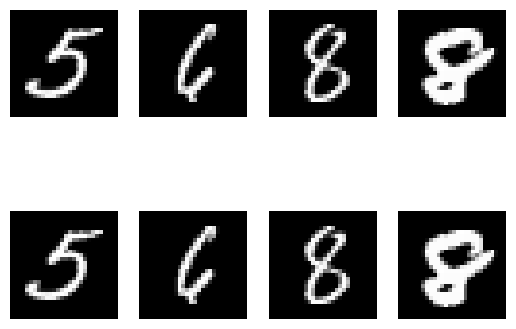

In [ ]:
# First possibility:
# input: a list of datasets
# behavior : select 4 images in the first dataset and display the corresponding images in the other sets
look([X, X])

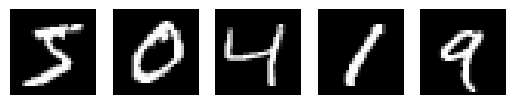

In [ ]:
# Second possibility:
# inputs: a list of images,
# behavior: display the image list
look([X[i] for i in range(5)])

## Part I. Build and fit an auto-encoder

**Don't use convolution layers** that we haven't yet seen in the course. Only use dense layers.

### Build a vanilla auto-encoder

* Encode input on dimension 10 using only one step.
* Choose correct activation function
    * relu or sigmoid for hidden layer,
    * sigmoid or linear for output layer
    * Remember: auto-encoder work well, if you add non-linearity
* Build vanilla-encoder, vanilla-decoder and vanilla-auto-encoder models
* Choose correct loss function
    * Generally, auto-encoder minimises $(y - \hat{y})^2$
* Use Earlystoppping
* Plot learning curve in order verify the learning process

You may have some indication on [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) (but you have to adapt it)

In [ ]:
# Build the vanilla auto-encoder
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# Input layer
import keras

input_layer = layers.Input(shape=(784,))

# Encoder
encoded = layers.Dense(10, activation='relu')(input_layer)

# Decoder
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# Create the auto-encoder model
autoencoder = models.Model(input_layer, decoded)

# Compile the auto-encoder
autoencoder.compile(optimizer="adam", loss='binary_crossentropy')

# This model maps an input to its encoded representation
encoder = keras.Model(input_layer, encoded)
encoded_input = keras.Input(shape=(10,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
# Fit your vanilla auto-encoder
history = autoencoder.fit(X, X, epochs=50, callbacks=[callbacks.EarlyStopping()], validation_data=(newImages, newImages));

Epoch 1/50
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2090 - val_loss: 0.1673
Epoch 2/50
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1652 - val_loss: 0.1610
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1605 - val_loss: 0.1573
Epoch 4/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1580 - val_loss: 0.1555
Epoch 5/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1567 - val_loss: 0.1547
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1560 - val_loss: 0.1540
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1555 - val_loss: 0.1536
Epoch 8/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1552 - val_loss: 0.1533
Epoch 9/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1549 - val_loss: 0.1531
Epoch 10/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1

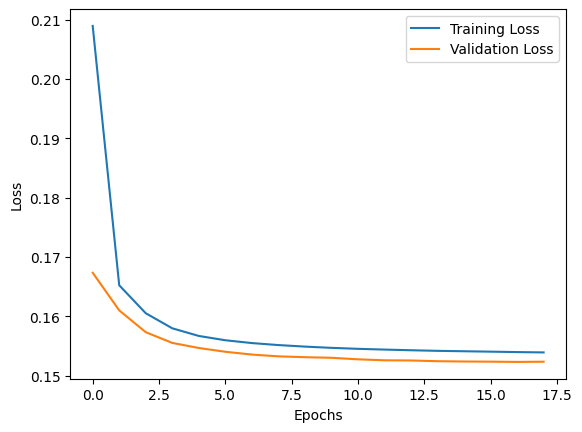

In [ ]:

# Plot the learning curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
decoded_images = autoencoder.predict(newImages)


313/313 [==============================] - 1s 2ms/step


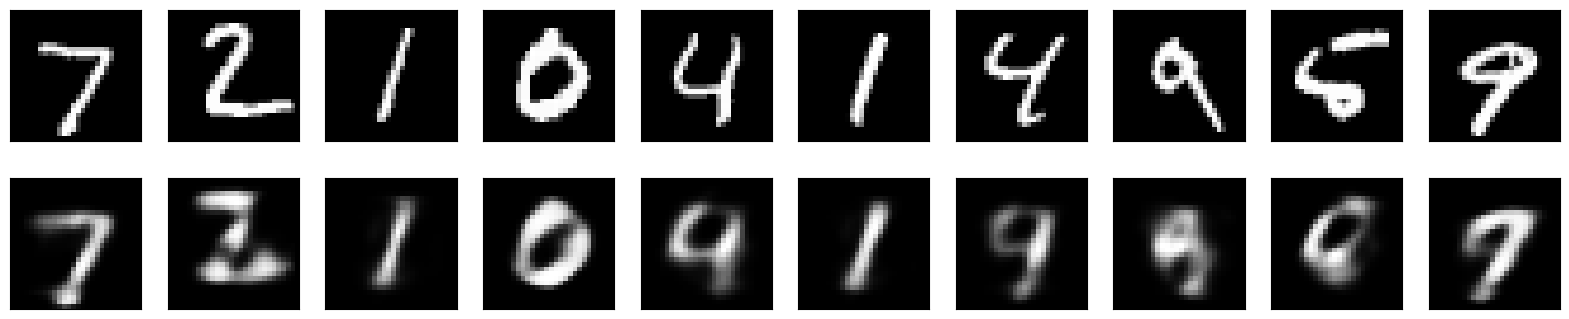

In [ ]:
# Use Matplotlib
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(newImages[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Build a stacked auto-encoder

Same question as above, but with a stacked auto-encoder with the following dimensions: [500, 500, 2000, 10].

Build deep-encoder, deep-decoder and deep-auto-encoder models

Train all layers simultaneously.

In [ ]:
# Build your deep auto-encoder
deep_layers = [500, 500, 2000, 10]

inputs = layers.Input(shape=(784,))
encoded = layers.Dense(deep_layers[0], activation='relu')(inputs)
for ed in deep_layers[1:]:
    encoded = layers.Dense(ed, activation='relu')(encoded)
decoded = encoded
for dec in reversed(deep_layers):
    decoded = layers.Dense(dec, activation='relu')(decoded)

outputs = layers.Dense(784, activation='sigmoid')(decoded)
deep_autoencoder = models.Model(inputs=inputs, outputs=outputs)

# Compile your deep auto-encoder
deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Fit your deep auto-encoder
history = deep_autoencoder.fit(X, X, epochs=50, batch_size=256, validation_data=(newImages, newImages), validation_batch_size=32, callbacks=[callbacks.EarlyStopping()]);


Epoch 1/50
235/235 [==============================] - 45s 184ms/step - loss: 0.2430 - val_loss: 0.1836
Epoch 2/50
235/235 [==============================] - 38s 161ms/step - loss: 0.1676 - val_loss: 0.1558
Epoch 3/50
235/235 [==============================] - 37s 156ms/step - loss: 0.1507 - val_loss: 0.1466
Epoch 4/50
235/235 [==============================] - 38s 162ms/step - loss: 0.1446 - val_loss: 0.1427
Epoch 5/50
235/235 [==============================] - 37s 156ms/step - loss: 0.1413 - val_loss: 0.1398
Epoch 6/50
235/235 [==============================] - 38s 160ms/step - loss: 0.1389 - val_loss: 0.1384
Epoch 7/50
235/235 [==============================] - 36s 155ms/step - loss: 0.1368 - val_loss: 0.1361
Epoch 8/50
235/235 [==============================] - 38s 163ms/step - loss: 0.1349 - val_loss: 0.1348
Epoch 9/50
235/235 [==============================] - 37s 160ms/step - loss: 0.1334 - val_loss: 0.1337
Epoch 10/50
235/235 [==============================] - 38s 163ms/step - l

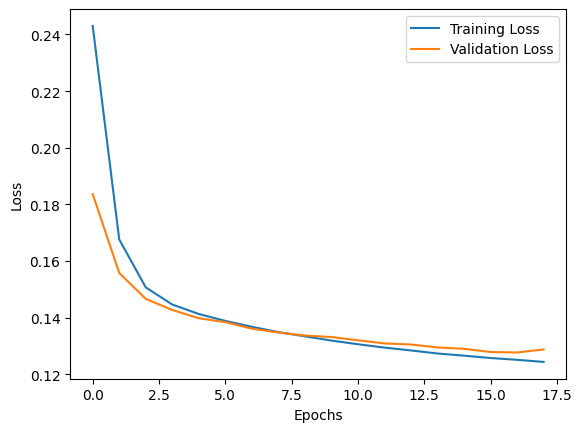

In [ ]:
# Plot the learning curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Use greedy approach to train "Deep Auto-Encoder"

It is generally difficult to set up a stacked auto-encoder by training all the layers simultaneously if there is too much layers. We therefore proceed layer by layer. The technical term is **greedy layer-wise pretraining** and this approach can be used to train deep networks by progressively adding new layers to be trained. The [following article](https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/) gives you an example of how it can be used.

How to proceed to train a [500, 500, 2000, 10]:
* Train a first auto-encoder (a1, e1): $X$ --> Dense(500) --> Dense(784) -> $\hat{X}$
* Save all weigths
* Encode the dataset with the previous encoder: $X1$ = e1.predict(X)
* do the same for the next layer (a2, e2): $X1$ --> Dense(500) --> Dense(500) -> $\hat{X2
* Save all weigths
* Encode the dataset with the previous encoder: $X2$ = e2.predict(X1)
* etc. until the last layer.

Then create a full auto-encoder [500, 500, 2000, 10]
* Initialise all weigths with the previously saved weights (a1, a2, a3, a4)
* Fine-tune the final one in order to obtain autoencoder3, encoder3

In [ ]:
def create_model(input_units, dimensions, encoder_weights, decoder_weights):
    input_layer = layers.Input(shape=(input_units,))

    x = input_layer
    # encoder segment
    for dim in dimensions:
        x = layers.Dense(dim, activation='relu')(x)

    # decoder segment
    for dim in list(reversed(dimensions))[1:]:
        x = layers.Dense(dim, activation='relu')(x)

    output_layer = layers.Dense(input_units, activation='sigmoid')(x)
    model = models.Model(input_layer, output_layer)

    for i, w in enumerate(encoder_weights, start=1):
        # encoder layers
        model.layers[i].set_weights(w)
        model.layers[i].trainable = False #the weights of this layer should not be updated during further training.
    for i, w in enumerate(decoder_weights, start=1):
        # decoder layers
        model.layers[-i].set_weights(w)
        model.layers[-i].trainable = False

    return model

def train_greedy_autoencoder(X, layer_dimensions, epochs=10, batch_size=256, optimization='adam', loss_function='binary_crossentropy', validation_X=None):
    input_dimensions = X.shape[1]
    encoder_weights = []
    decoder_weights = []

    model = create_model(input_dimensions, [layer_dimensions[0]], [], [])
    model.compile(optimizer=optimization, loss=loss_function)

    print(f"Training layer 1")
    model.fit(X ,X, batch_size=batch_size, epochs=epochs)

    for i in range(2, len(layer_dimensions) + 1):
        # save weights of previous layers
        encoder_weights.append(model.layers[i-1].get_weights())
        decoder_weights.append(model.layers[-i+1].get_weights())

        model = create_model(input_dimensions, layer_dimensions[:i], encoder_weights, decoder_weights)
        model.compile(optimizer=optimization, loss=loss_function)

        print(f"Training of layer {i}")
        model.fit(X, X, batch_size=batch_size, epochs=epochs)

    full_autoencoder = create_model(input_dimensions, layer_dimensions, encoder_weights, decoder_weights)
    for layer in full_autoencoder.layers:
        layer.trainable = True
    full_autoencoder.compile(optimizer=optimization, loss=loss_function)

    history = full_autoencoder.fit(X, X,
                                   epochs=epochs,
                                   batch_size=batch_size,
                                   validation_data=(validation_X, validation_X),
                                   validation_batch_size=64,
                                   callbacks=[callbacks.EarlyStopping()]
                                )
    return history, full_autoencoder

In [ ]:
hist, greedy_a = train_greedy_autoencoder(X, [500, 500, 2000, 10], epochs=50, validation_X=newImages)

In [ ]:
# Plot the learning curve
plt.plot(hist.hist['loss'], label='Training Loss')
plt.plot(hist.hist['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Part II : Use of the auto-encoders

It's time to use the prepared auto-encoders.

### Comparing reconstructions

using the look function, you can :
* apply the predict method of the auto-encoders built to the dataset
* view the reconstruction of some images.

In [ ]:
decoded_images = autoencoder.predict(newImages)
# Use Matplotlib
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(newImages[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
decoded_images = greedy_a.predict(newImages)
# Use Matplotlib
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(newImages[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Morphing

In this section, we will perturb the latent representation before decoding. Perturbations will be represented as additive noise. We will also explore the latent space by searching for latent vectors in the neighbourhood of some latent representation of training samples and see how the decoding representation looks like.

To do this:
* Choose 2 images: source and destination
* Encode each of these images using an auto-encoder (take the one that works best for you).
* Create a list containing
    * first element: the source
    * various elements (you choose the number) built from $\alpha \%$ of the source and $(1-\alpha) \%$ of the destination (increasing value of x between 0 and 1)
    * last element: the destination
* Decode each of the elements in the list and display them using the previous look function

In [ ]:
#Morphing, short for metamorphosis,
#refers to a process of smoothly transforming one image into another.
def custom_encode(encoder, image):
    """Encode an image using the given encoder."""
    return encoder.predict(np.array([image]))[0]

def custom_decode(decoder, encoded_image):
    """Decode an encoded image using the given decoder."""
    return decoder.predict(np.array([encoded_image]))[0]

def morph_images_custom_names(encoder, decoder, source_img, destination_img, steps=10):
    # Encode the source and destination images to get their latent representations
    source_encoded = custom_encode(encoder, source_img)
    destination_encoded = custom_encode(encoder, destination_img)

    # Interpolate between the source and destination in the latent space
    interpolated_images = []
    for step in range(steps + 1):
        alpha = step / steps
        interpolated_encoded = alpha * source_encoded + (1 - alpha) * destination_encoded
        interpolated_images.append(interpolated_encoded)

    # Decode the interpolated representations to images
    decoded_images = [custom_decode(decoder, encoded) for encoded in interpolated_images]

    # Display the images
    plt.figure(figsize=(20, 4))
    for i, img in enumerate(decoded_images):
        plt.subplot(1, len(decoded_images), i + 1)
        plt.imshow(img.reshape(28, 28), cmap='gray')  # Assuming grayscale images
        plt.title(f'Alpha: {i/steps:.2f}')
        plt.axis('off')
    plt.show()

    #interpolation refers to the process of generating intermediate values between two known values.
    #In this case, the known values are the encoded representations of a source image and a destination
    # image. The goal is to generate a series of intermediate representations (latent vectors) that smoothly transition from the source to the destination in the latent space.

1/1 [==============================] - 0s 23ms/step


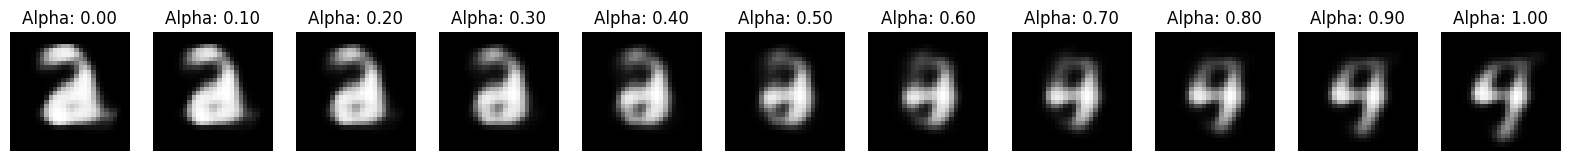

In [ ]:
src_img = newImages[random.randint(0, len(newImages))]
dest_img = newImages[random.randint(0, len(newImages))]

morph_images_custom_names(encoder, decoder, src_img, dest_img)

## Part 3 - Deep clustering

### Baseline with KMean (classical approach for clustering)

Build a baseline and evaluate it

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = newImages

# Perform k-means clustering
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42) #The n_init parameter in k-means clustering is the number of times the algorithm will be run with different centroid seeds.
#a higher value of n_init increases the chances of finding a globally optimal solution.
kmeans.fit(X)
y_pred = kmeans.predict(X)

# Calculate silhouette score
silhouette_avg = silhouette_score(X, y_pred)
#The silhouette score ranges from -1 to 1,
#where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
# Print silhouette score
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.05892796069383621


### DCN: use latent representation for clustering

Use a latent reprensentation for clustering. Evaluate the result.

In [ ]:
from tensorflow.keras import layers, models, callbacks


# Define the input layer
inp_layer = layers.Input(shape=(X.shape[1],))

# Encoder layers
encoded = layers.Dense(128, activation='relu')(inp_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

# Decoder layers
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(X.shape[1], activation='sigmoid')(decoded)

# Create autoencoder model
autoencode = models.Model(inp_layer, decoded)

encoder = models.Model(inp_layer, encoded)

# Compile the autoencoder model
autoencode.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder model
dcn_hist = autoencode.fit(
    X,
    X,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(newImages, newImages),  # Validation data
    callbacks=[callbacks.EarlyStopping()]  # Early stopping callback
)

Epoch 1/50
40/40 [==============================] - 5s 70ms/step - loss: 0.4138 - val_loss: 0.2722
Epoch 2/50
40/40 [==============================] - 2s 54ms/step - loss: 0.2627 - val_loss: 0.2516
Epoch 3/50
40/40 [==============================] - 2s 55ms/step - loss: 0.2385 - val_loss: 0.2207
Epoch 4/50
40/40 [==============================] - 2s 47ms/step - loss: 0.2052 - val_loss: 0.1898
Epoch 5/50
40/40 [==============================] - 2s 44ms/step - loss: 0.1826 - val_loss: 0.1761
Epoch 6/50
40/40 [==============================] - 2s 47ms/step - loss: 0.1717 - val_loss: 0.1676
Epoch 7/50
40/40 [==============================] - 2s 51ms/step - loss: 0.1614 - val_loss: 0.1568
Epoch 8/50
40/40 [==============================] - 2s 47ms/step - loss: 0.1538 - val_loss: 0.1502
Epoch 9/50
40/40 [==============================] - 2s 55ms/step - loss: 0.1485 - val_loss: 0.1463
Epoch 10/50
40/40 [==============================] - 3s 76ms/step - loss: 0.1446 - val_loss: 0.1443
Epoch 11/

In [ ]:
def plot_history(history, plot_val=False):
    lh = plt.plot(history.history['loss'], label="training")
    if plot_val and 'val_loss' in history.history:
        vlh = plt.plot(history.history['val_loss'], label="validation")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    # plt.title("Loss")
    plt.legend()

    plt.show()
    plot_history(dcn_hist, plot_val=True)

In [ ]:
plot_model_predictions(autoencoder)

In [ ]:
latent_X = encoder.predict(X)

313/313 [==============================] - 1s 2ms/step


In [ ]:
dcn_kmeans = KMeans(n_clusters=nb_classes, n_init=nb_classes)
dcn_preds = dcn_kmeans.fit_predict(latent_X)

In [ ]:
silhouette_avg = silhouette_score(latent_X, dcn_preds)
print(f"Silhouette Score: {silhouette_avg}")

### N2D: add a mainfold mapping before clustering

Map the latent representation before clustering. Evaluate the result.

In [ ]:
#"manifold mapping" refers to the process of transforming or
#projecting data from a high-dimensional space to a lower-dimensional space while preserving certain structural characteristics of the data.
manifold_kmeans = KMeans(n_clusters=nb_classes, n_init=nb_classes)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
manifold_projection = tsne.fit_transform(latent_X)
#the result of transforming the original latent representations (latent_X) using t-SNE
preds = dcn_kmeans.fit_predict(manifold_projection)

silhouette_avg = silhouette_score(latent_X, dcn_preds)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.14393137395381927
